                                       Attribute  Score      Exponent  \
0                         Social Security Number   9.40  12088.380730   
1                Financial & Banking Information   9.17   9604.624690   
2                                 Biometric Data   8.46   4722.057998   
3           Health Insurance Policy or ID Number   8.44   4628.554985   
4  Driver's License or Washington ID Card Number   8.39   4402.817694   
5                                Passport Number   8.38   4359.008926   
6                            Medical Information   8.36   4272.694766   
7                             Full Date of Birth   6.02    411.578596   
8                                          Other   8.43   4582.500093   
9                              Username/Password   9.27  10614.751886   

     Weight  
0  0.202530  
1  0.160917  
2  0.079114  
3  0.077547  
4  0.073765  
5  0.073031  
6  0.071585  
7  0.006896  
8  0.076776  
9  0.177840  
Organization Name
Brightly Software, Inc. 

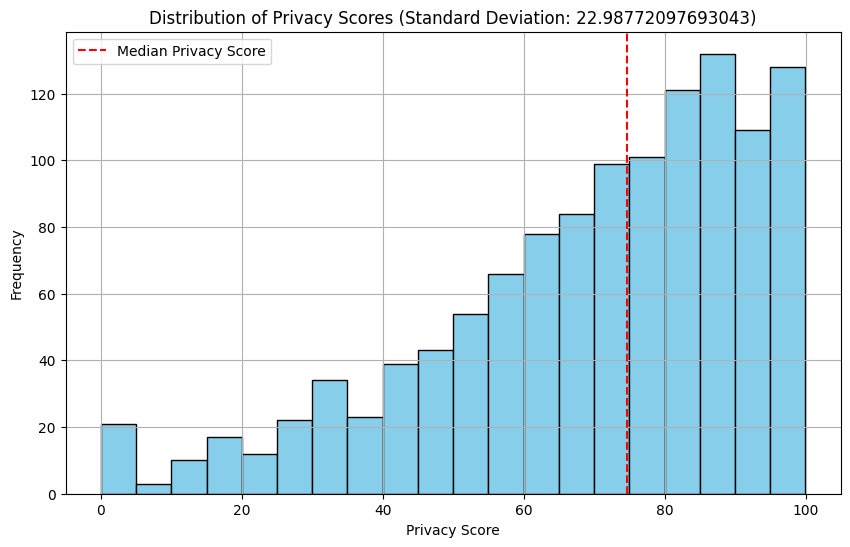

In [ ]:
# Final Version of the Privacy Score formula calculation
# Alex, Ben, and Spencer

import pandas as pd
from scipy.special import expit
import numpy as np
from google.colab import files

# Read data from Excel file
df = pd.read_excel('Washington Data Collection.xlsx')
df.head()

# Find unique column names
unique_columns = set(';'.join(df['Information Compromised'].str.split('; ').sum()).split(';'))

# Create dummy variables for each unique column -- ERROR
for col in unique_columns:
    df[col.strip()] = df['Information Compromised'].str.contains(col, regex=False)

# Drop the original 'Information Compromised' column
df.drop(columns=['Information Compromised'], inplace=True)

from datetime import datetime

# Define today's date
today = datetime.now()

# convert dates to datetime
df['Date Reported'] = pd.to_datetime(df['Date Reported'])
df['Date of Breach'] = pd.to_datetime(df['Date of Breach'])

# Calculate the difference in days between the dates
df['DaysToReport'] = abs((df['Date Reported'] - df['Date of Breach']).dt.days)

# Calculate the difference in days between today and the date of the breach
df['DaysSinceBreach'] = (today - df['Date of Breach']).dt.days

# Merge the columns into one
df['Other'] = df[['Unknown', 'Name', 'Student ID Number', 'Military ID Number']].any(axis=1)
df['Username/Password'] = df[['Email Address and Password/Security Question Answers', 'Username and Password/Security Question Answers', 'Unique Private Key (e.g. used to authenticate or sign an electronic record)']].any(axis=1)

# Drop the original columns if needed
df.drop(columns=['Date Reported', 'Date of Breach', 'Name', 'Unknown', 'Student ID Number', 'Military ID Number', 'Email Address and Password/Security Question Answers', 'Username and Password/Security Question Answers', 'Unique Private Key (e.g. used to authenticate or sign an electronic record)'], inplace=True)

def get_sum_of_non_na(column):
    non_na_values = column[column != "Unknown"].dropna()
    if non_na_values.dtype == 'float64' or non_na_values.dtype == 'int64':
        res = non_na_values.sum()
        return res
    else:
        return non_na_values.sum()

def get_median_of_non_na(column):
    non_na_values = column[column != "Unknown"].dropna()
    if non_na_values.dtype == 'float64' or non_na_values.dtype == 'int64':
        res = non_na_values.median()
        return res
    else:
        return non_na_values.median()

# Assuming 'Number of Washingtonians Affected' is numeric, convert it to integer
df['Number of Washingtonians Affected'] = pd.to_numeric(df['Number of Washingtonians Affected'], errors='coerce').fillna(get_sum_of_non_na(df['Number of Washingtonians Affected'])).astype(int)
df['DaysSinceBreach'] = pd.to_numeric(df['DaysSinceBreach'], errors='coerce').fillna(get_median_of_non_na(df['DaysSinceBreach'])).astype(int)
df['DaysToReport'] = pd.to_numeric(df['DaysToReport'], errors='coerce').fillna(get_median_of_non_na(df['DaysToReport'])).astype(int)

df_grouped = df.groupby('Organization Name').agg({
    'DaysSinceBreach': 'min',
    'DaysToReport': 'mean',
    **{col: 'sum' for col in df.columns if col not in ['DaysSinceBreach', 'DaysToReport']}
})

# Adding Rank Values for numbered columns
# Calculate mean rank for each column
columns_to_rank = ["Number of Washingtonians Affected", "DaysSinceBreach", "DaysToReport",
                   "Driver's License or Washington ID Card Number", "Social Security Number",
                   "Full Date of Birth", "Financial & Banking Information", "Other",
                   "Username/Password", "Passport Number", "Medical Information",
                   "Biometric Data", "Health Insurance Policy or ID Number"]

for column in columns_to_rank:
    # Calculate the mean rank
    df_grouped[column + ' Rank'] = df_grouped[column].rank(method='average')

# Sort by any specific column if needed
df_sorted = df_grouped.sort_values(by='Number of Washingtonians Affected')

import math
columns_with_rank = []
# Get values between 0 or 1. Values of 1 indicate that the organization had the most occurance or most severe breach for that attribute
for column in df_sorted.columns:
  if "Rank" in column:
    df_sorted[column] /= len(df_sorted[column])
    columns_with_rank.append(column)



# Assign scores to breach types
raw_scores = {
    'Social Security Number': 9.40,
    'Financial & Banking Information': 9.17,
    'Biometric Data': 8.46,
    'Health Insurance Policy or ID Number': 8.44,
    "Driver's License or Washington ID Card Number": 8.39,
    'Passport Number': 8.38,
    'Medical Information': 8.36,
    'Full Date of Birth': 6.02,
    'Other': 8.43,
    'Username/Password': 9.27
}

df_weights = pd.DataFrame(list(raw_scores.items()), columns=['Attribute', 'Score'])

# Calculate the exponent of each score
df_weights['Exponent'] = df_weights['Score'].apply(lambda x: np.exp(x))

# Calculate the sum of exponent scores
sum_exponent = df_weights['Exponent'].sum()

# Calculate the weights using exponent(score) / sum exponent(scores)
df_weights['Weight'] = df_weights['Exponent'] / sum_exponent

print(df_weights)


# Initialize the Privacy Score to be 100 for each organization
df_sorted['Privacy Score'] = 100
df_sorted['Penalty'] = 0

# Apply weights to the privacy score
for attribute in df_weights['Attribute']:
  if attribute in df_sorted.columns:
    attribute_weight = df_weights.loc[df_weights['Attribute'] == attribute, 'Weight'].values[0]*100
    df_sorted['Penalty'] = df_sorted.apply(lambda row: row['Penalty'] + row[str(attribute) + ' Rank']*attribute_weight, axis=1)

df_sorted['Penalty'] = df_sorted.apply(lambda row: row['Penalty'] * 1.0005**(-row['DaysSinceBreach']), axis=1)
df_sorted['Penalty'] = df_sorted.apply(lambda row: row['Penalty'] * 1.0005**(row['DaysToReport']), axis=1)
df_sorted['Penalty'] = df_sorted.apply(lambda row: row['Penalty'] * 1.5 * row['Number of Washingtonians Affected Rank'], axis=1)
df_sorted['Privacy Score'] = df_sorted.apply(lambda row: row['Privacy Score'] - min(row['Penalty'],100), axis=1)

df_sorted = df_sorted.sort_values(by="Privacy Score", ascending=False)
print(df_sorted['Privacy Score'].head(50))
print(df_sorted['Privacy Score'].tail(50))

df_sorted.drop(columns=columns_with_rank, inplace=True)
df_sorted.drop(columns=['Penalty'], inplace=True)
#df_sorted.to_excel('privacyScores.xlsx', index=False)
#files.download('privacyScores.xlsx')

import matplotlib.pyplot as plt

# Calculate the median
median_privacy_score = df_sorted['Privacy Score'].median()
standard_deviation = df_sorted['Privacy Score'].std()
print("Median: ", median_privacy_score)
print("Standard Deviation", standard_deviation)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_sorted['Privacy Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Privacy Scores (Standard Deviation: ' + str(standard_deviation) + ')')
plt.xlabel('Privacy Score')
plt.ylabel('Frequency')
plt.grid(True)

# Overlaying a vertical line at the median
plt.axvline(x=median_privacy_score, color='red', linestyle='--', label='Median Privacy Score')

# Adding legend
plt.legend()

plt.show()


Organization Name
1st Source Bank                                             89.545403
20/20 Eye Care Network, Inc.                                72.230675
21st Century Oncology                                       69.063099
32 Bar Blues LLC                                             0.556227
5th Avenue Theatre Association                              93.447447
90 Degree Benefits, Inc. - Wisconsin                        74.965498
90 Degree Benefits, Inc. Wisconsin                          78.511514
A&A Global Imports Inc.                                      0.556172
A. Duda & Sons Inc.                                         90.341609
AARP, Inc. & AARP Foundation                                54.068519
AARP.org                                                    93.275538
ABM Industries Incorporated                                 14.968366
ACTIVEOutdoors                                              28.535691
AFTRA Retirement Fund                                       74.708541
AI

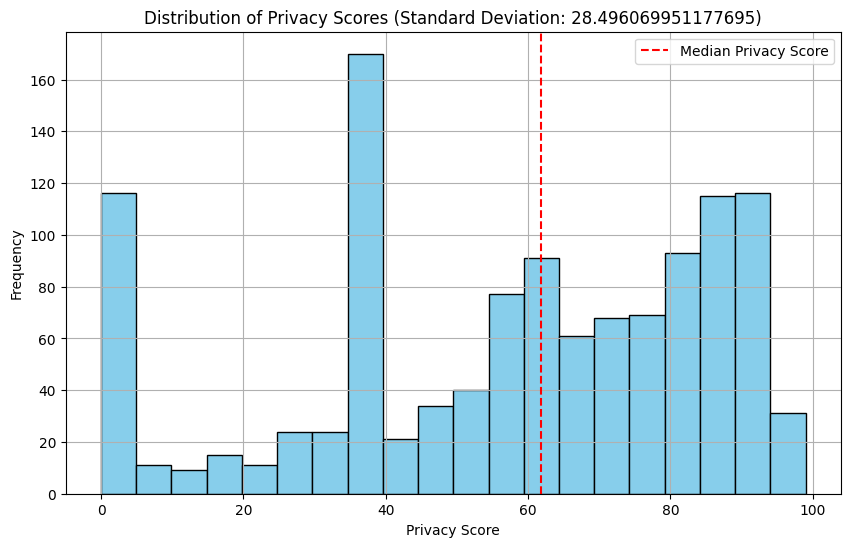

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# This is the original, non used formula that we desrcribed in the experiments section of the report

import pandas as pd
from scipy.special import expit
import numpy as np
from google.colab import files

# Read data from Excel file
df = pd.read_excel('Washington Data Collection.xlsx')
df.head()

# Find unique column names
unique_columns = set(';'.join(df['Information Compromised'].str.split('; ').sum()).split(';'))

# Create dummy variables for each unique column -- ERROR
for col in unique_columns:
    df[col.strip()] = df['Information Compromised'].str.contains(col, regex=False)

# Drop the original 'Information Compromised' column
df.drop(columns=['Information Compromised'], inplace=True)

from datetime import datetime

# Define today's date
today = datetime.now()

# Group By Company, Total Number of Breaches, Average Time From Breach to Report, total number of each type of breach, date of most recent breach

# convert dates to datetime
df['Date Reported'] = pd.to_datetime(df['Date Reported'])
df['Date of Breach'] = pd.to_datetime(df['Date of Breach'])

# Calculate the difference in days between the dates
df['DaysToReport'] = abs((df['Date Reported'] - df['Date of Breach']).dt.days)

# Calculate the difference in days between today and the date of the breach
df['DaysSinceBreach'] = (today - df['Date of Breach']).dt.days

# Merge the columns into one
df['Other'] = df[['Unknown', 'Name', 'Student ID Number', 'Military ID Number']].any(axis=1)
df['Username/Password'] = df[['Email Address and Password/Security Question Answers', 'Username and Password/Security Question Answers', 'Unique Private Key (e.g. used to authenticate or sign an electronic record)']].any(axis=1)

# Drop the original columns if needed
df.drop(columns=['Date Reported', 'Date of Breach', 'Unknown', 'Student ID Number', 'Military ID Number', 'Email Address and Password/Security Question Answers', 'Username and Password/Security Question Answers', 'Unique Private Key (e.g. used to authenticate or sign an electronic record)'], inplace=True)

def get_sum_of_non_na(column):
    non_na_values = column[column != "Unknown"].dropna()
    if non_na_values.dtype == 'float64' or non_na_values.dtype == 'int64':
        res = non_na_values.sum()
        return res
    else:
        return non_na_values.sum()

# Assuming 'Number of Washingtonians Affected' is numeric, convert it to integer
df['Number of Washingtonians Affected'] = pd.to_numeric(df['Number of Washingtonians Affected'], errors='coerce').fillna(get_sum_of_non_na(df['Number of Washingtonians Affected'])).astype(int)

df_grouped = df.groupby('Organization Name').agg({
    'DaysSinceBreach': 'min',
    'DaysToReport': 'mean',
    **{col: 'sum' for col in df.columns if col not in ['DaysSinceBreach', 'DaysToReport']}
})

# Find the median of these attributes to scale
median_days_to_report = df_grouped['DaysToReport'].median()
median_num_affected = df_grouped['Number of Washingtonians Affected'].median()

# Calculate the scalars
df_grouped['Scalar DaysToReport'] = df_grouped['DaysToReport'] / median_days_to_report
df_grouped['Scalar Number of Washingtonians Affected'] = df_grouped['Number of Washingtonians Affected'] / median_num_affected

# Normalize to range centered around 1 (where higher is better)
df_grouped['Norm Scalar DaysToReport'] = 2 - ((df_grouped['Scalar DaysToReport'] - df_grouped['Scalar DaysToReport'].mean()) / df_grouped['Scalar DaysToReport'].std() + 1)
df_grouped['Norm Scalar Number of Washingtonians Affected'] = 2 - ((df_grouped['Scalar Number of Washingtonians Affected'] - df_grouped['Scalar Number of Washingtonians Affected'].mean()) / df_grouped['Scalar Number of Washingtonians Affected'].std() + 1)

# Clip values to keep them within a reasonable range
df_grouped['Norm Scalar DaysToReport'] = df_grouped['Norm Scalar DaysToReport'].clip(lower=0.01)
df_grouped['Norm Scalar Number of Washingtonians Affected'] = df_grouped['Norm Scalar Number of Washingtonians Affected'].clip(lower=0.01)

# get mean and sd of days to report
mean_days_to_report = df_grouped['Norm Scalar DaysToReport'].mean()
std_days_to_report = df_grouped['Norm Scalar DaysToReport'].std()

# Compute the replacement value (mean minus one standard deviation)
replacement_value = mean_days_to_report - std_days_to_report

# Replace NaN values with the computed replacement value
df_grouped['Norm Scalar DaysToReport'].fillna(replacement_value, inplace=True)

# Calculate the privacy score
df_grouped['Privacy Score'] = df_grouped['Norm Scalar DaysToReport'] * df_grouped['Norm Scalar Number of Washingtonians Affected']

# Assign scores to breach types
raw_scores = {
    'Social Security Number': 9.40,
    'Financial & Banking Information': 9.17,
    'Biometric Data': 8.46,
    'Health Insurance Policy or ID Number': 8.44,
    "Driver's License or Washington ID Card Number": 8.39,
    'Passport Number': 8.38,
    'Medical Information': 8.36,
    'Full Date of Birth': 6.02,
    'Other': 8.43,
    'Username/Password': 9.27
}

df_weights = pd.DataFrame(list(raw_scores.items()), columns=['Attribute', 'Score'])

# Calculate the exponent of each score
df_weights['Exponent'] = df_weights['Score'].apply(lambda x: np.exp(x))

# Calculate the sum of exponent scores
sum_exponent = df_weights['Exponent'].sum()

# Calculate the weights using exponent(score) / sum exponent(scores)
df_weights['Weight'] = df_weights['Exponent'] / sum_exponent

# Apply weights to the privacy score
for attribute in df_weights['Attribute']:
    if attribute in df_grouped.columns:
        df_grouped['Privacy Score'] *= df_weights.loc[df_weights['Attribute'] == attribute, 'Weight'].values[0]

# Replace NaN values in Privacy Score with 0 (or another placeholder if necessary)
df_grouped['Privacy Score'].fillna(0, inplace=True)

# Min-max normalization to scale Privacy Score to range 0-99
min_score = df_grouped['Privacy Score'].min()
max_score = df_grouped['Privacy Score'].max()

df_grouped['Scaled Privacy Score'] = 99 * (df_grouped['Privacy Score'] - min_score) / (max_score - min_score)

print(df_grouped['Scaled Privacy Score'].head(50))
df_grouped.to_excel('dataframe.xlsx', index=False)

import matplotlib.pyplot as plt

# Calculate the median
median_privacy_score = df_grouped['Scaled Privacy Score'].median()
standard_deviation = df_grouped['Scaled Privacy Score'].std()
print("Median: ", median_privacy_score)
print("Standard Deviation", standard_deviation)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_grouped['Scaled Privacy Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Privacy Scores (Standard Deviation: ' + str(standard_deviation) + ')')
plt.xlabel('Privacy Score')
plt.ylabel('Frequency')
plt.grid(True)

# Overlaying a vertical line at the median
plt.axvline(x=median_privacy_score, color='red', linestyle='--', label='Median Privacy Score')

# Adding legend
plt.legend()

plt.show()

files.download('dataframe.xlsx')
